# 生成回归数据

In [35]:
import numpy as np
from sklearn.datasets import make_regression

# 创建回归问题的示例数据
feature, target = make_regression(n_samples=100, n_features=5, n_informative=3, random_state=666, noise=10)
print(feature.shape, target.shape)

(100, 5) (100,)


# 多元线性回归

1. $y=\beta_{0}+\beta_{1}x_{1}+\cdots+\beta_{p}x_{p}+\epsilon$
2. 基本假设
   - 回归模型设定是正确的
   - 对于每个$x_{j}$,$0 < j \le k$具有变异性。同时，样本量最少满足$n \ge k+1$，且$X_{j}$之间不存在多重共线性
   - 随机干扰项条件零均值$E(\mu | X)=0$
   - 随机干扰项条件同方差与序列不相关
   - 随机干扰项正态分布

## 多重共线性检验(方差膨胀因子VIF)
- $VIF_{i}=\frac{1}{1-R_{i}^{2}}$
- 其中$R_{i}$为第$i$个变量$X_{i}$与其他全部变量$X_{j},(i=1,2,3,\cdots,k;i \ne j)$的复相关系数；

>复相关系数即可决系数$R^{2}$的算术平方根，也即拟合优度的算术平方根。
>这个可决系数$R_{i}^{2}$是指用$X_{i}$做因变量，对其他全部$X_{j},(i=1,2,3,\cdots,k;i \ne j)$做一个新的回归以后得到的可决系数。

- $VIF$通常以10作为判断边界。
  - 当$VIF < 10$,不存在多重共线性；
  - 当$10 \le VIF < 100$,存在较强的多重共线性；
  - 当$VIF \ge 100$, 存在严重多重共线性。
1. 多重共线性是普遍存在的，轻微的多重共线性问题可不采取措施。 
2. 严重的多重共线性问题，一般可根据经验或通过分析回归结果发现。如影响系数符号，重要的解释变量t值很低。要根据不同情况采取必要措施。
3. 如果模型仅用于预测，则只要拟合程度好，可不处理多重共线性问题，存在多重共线性的模型用于预测时，往往不影响预测结果。

In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 输入变量
# exog：所有解释变量
# exog_idx：解释变量的columns标签
for i in range(feature.shape[1]):
    print(f"第{i+1}个解释变量的VIF值为{variance_inflation_factor(feature, i)}")

第1个解释变量的VIF值为1.0178428500731205
第2个解释变量的VIF值为1.0557687457903961
第3个解释变量的VIF值为1.050193743296577
第4个解释变量的VIF值为1.057475238205702
第5个解释变量的VIF值为1.061732811081109


## 多重共线性处理
- 实际应用中，若存在多重共线性，需要消除多重共线性，不能直接建立多元线性回归模型；
- 待补充
# 变量间相关性分析
## 正态检验
- Pearson相关系数以及典型相关分析都要求样本数据满足正态分布的要求
- 因此首先对样本数据的正态分布进行检验
    - **JB检验**(大样本 n>30)
    - **Shapior-wilk检验**(小样本 3<n<50)
    - **KS检验**(Kolmogorov-Smirnov)

In [37]:
print("样本数量", feature.shape[0])

样本数量 100


In [38]:
# 检验每个随机变量是否服从正态分布
from scipy import stats
for i in range(feature.shape[1]):
    jb_value, p = stats.jarque_bera(feature[:,i])
    if p < 0.05:
        judge = '拒绝原假设'
    else:
        judge = '接受原假设'
    print(f"第{i}个变量的Test Statstic（显著性水平）为{jb_value}, P值为:{p}, {judge}")

第0个变量的Test Statstic（显著性水平）为1.0607200928419227, P值为:0.5883930827125233, 接受原假设
第1个变量的Test Statstic（显著性水平）为0.31642910793164014, P值为:0.8536666047629464, 接受原假设
第2个变量的Test Statstic（显著性水平）为2.6783809379997727, P值为:0.26205772658847204, 接受原假设
第3个变量的Test Statstic（显著性水平）为1.525444144712115, P值为:0.4663951362148422, 接受原假设
第4个变量的Test Statstic（显著性水平）为2.7153619656833237, P值为:0.2572566683733464, 接受原假设


## Pearson相关系数

In [39]:
import pandas as pd

pd.DataFrame(feature).corr(method='pearson')  # pearson 互相关系数

,0,1,2,3,4
0,1.000000,-0.034239,-0.026433,0.122607,-0.074565
1,-0.034239,1.000000,0.062862,-0.065280,-0.209959
2,-0.026433,0.062862,1.000000,-0.200150,-0.096902
3,0.122607,-0.065280,-0.200150,1.000000,0.026778
4,-0.074565,-0.209959,-0.096902,0.026778,1.000000


# 建立多元回归模型
## 拟合模型
- R-squared，即表示拟合优度$R^{2}$，用来衡量估计的模型对观测值的拟合程度。它的值越接近1说明模型越好;
- Adj.R-squared，即调整后的$R^{2}$，同时考虑了样本量$n$和回归中自变量的个数$k$的影响;
- F-statistic：方差分析
  - $H_{0}:$所有回归系数都等于零。$H_{1}:$所有回归系数不全为零。
  - 若Prob (F-statistic)即P值小于0.05，则拒绝原假设，认为多元线性回归模型总体显著。
  - 若$F > F_{\alpha}(K_{n},-k-1)$，则接受原假设，认为多元线性回归模型总体不显著。
  - 若$F \le F_{\alpha}(K_{n},-k-1)$，则拒绝原假设，认为多元线性回归模型总体显著。
- 单个变量的显著性检验：t统计量
  - 与F统计量类似，若P值小于0.05，则拒绝原假设，认为该自变量显著，对因变量解释性较强。

In [40]:
# 可以通过Scipy计算F统计量和T统计量
from scipy.stats import f, t
F_Theroy = f.ppf(q=0.95, dfn=5, dfd=10-5-1)
print('F: {}'.format(F_Theroy))
T_Theroy = t.ppf(q=0.975, df=100-5-1)
print('T: {}'.format(T_Theroy))

F: 6.2560565021608845
T: 1.9855234417658298


In [41]:
import statsmodels.api as sm

X = feature
Y = target 
X = sm.add_constant(X) # 添加截距项, 通常是1，方便拟合
print(X.shape)
model = sm.OLS(Y,X).fit()  # 普通最小二乘法（Ordinary Least Squares, OLS）拟合
print(model.summary())

(100, 6)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     1797.
Date:                Fri, 26 Jan 2024   Prob (F-statistic):           1.26e-91
Time:                        19:48:20   Log-Likelihood:                -368.63
No. Observations:                 100   AIC:                             749.3
Df Residuals:                      94   BIC:                             764.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5438      1.033     -1.495

这个多变量线性回归模型的统计结果提供了丰富的信息，我们可以从多个角度来分析模型的效果：

1. **R²和调整后的R²（Adj. R-squared）**: 这两个指标均为1.000，这通常表示模型完美地拟合了数据。在现实世界的数据分析中，这种情况非常罕见，通常可能意味着数据存在过拟合，或者数据之间存在完全的线性关系。

2. **F统计量（F-statistic）和其概率（Prob (F-statistic)）**: F统计量非常大（2.498e+31），而且其对应的概率（p值）为0.00，这通常表示模型中至少有一个解释变量对因变量有显著影响。然而，这种极端的统计量通常在完美或几乎完美的数据拟合中出现，这在现实数据中是不常见的。

3. **系数（coef）和t检验**: 每个自变量的系数都有相应的t值和p值。对于`x1`、`x2`和`x3`，它们的p值为0.000，表明这些变量在统计上对因变量有显著影响。但是，由于这些系数的标准误差非常小（几乎为零），这又指向了数据可能存在过拟合的问题。

4. **标准误差（std err）**: 标准误差非常小，这通常不是一个现实的结果，可能表明数据之间存在完美的线性关系或者是人工生成的。

5. **Omnibus和Jarque-Bera（JB）测试**: 这些是用于检测残差是否呈正态分布的测试。在这个模型中，这些测试的p值较高（0.551和0.615），表明残差可能接近正态分布。

6. **Durbin-Watson（DW）统计量**: 该统计量值为1.872，接近2，这通常表示残差中不存在自相关性。

7. **条件数（Cond. No.）**: 条件数为1.51，这是一个非常小的数值，表明模型中没有多重共线性的问题。

综合以上信息，虽然模型在统计上看起来“完美”，但实际上它很可能是过拟合的，特别是在现实世界的数据分析中。在实践中，这种完美拟合通常表明数据中可能存在某种问题，如数据泄露（模型意外地访问了测试数据中的信息）或者变量之间存在完全的线性关系。因此，这样的模型可能无法很好地泛化到新的、未见过的数据上。

结果中的AIC（Akaike Information Criterion，赤池信息量准则）和BIC（Bayesian Information Criterion，贝叶斯信息准则）都是用来评估模型拟合优度的统计量，同时考虑了模型的复杂度。简而言之，它们都是平衡拟合优度和模型简洁性的指标。

1. **AIC（赤池信息量准则）**: 
    - AIC的基本思想是寻找可以最好地解释数据但包含最少自由参数的模型。
    - 它基于信息熵的概念，旨在最小化模型和真实数据之间的信息损失。
    - AIC计算公式为：\( AIC = 2k - 2\ln(L) \)，其中 \( k \) 是模型中参数的数量，\( \ln(L) \) 是似然函数的最大值（数据在模型下的概率）。
    - 在比较多个模型时，AIC值较低的模型通常被认为是更好的模型。

2. **BIC（贝叶斯信息准则）**:
    - BIC类似于AIC，但对模型中参数的惩罚更严厉，因此更倾向于选择参数更少的模型。
    - BIC的计算公式为：\( BIC = \ln(n)k - 2\ln(L) \)，其中 \( n \) 是观测值的数量。
    - 同样，在比较多个模型时，较低的BIC值表明模型可能更好。

在模型选择时，AIC和BIC都是有用的指标，它们可以帮助识别出在解释数据的同时保持参数数量合理的模型。通常情况下，选择AIC和BIC值较低的模型更为合适。但是，它们不应该是唯一的决策依据，模型的选择还应考虑其他因素，如理论基础、模型解释力和预测能力等。

## 绘制拟合图
由于解释变量（自变量X）是高维变量，不容易直接可视化X与Y的线性关系，所以在这里仅仅将y与y的预测值绘制出来。

(100, 6) (100,) (100,)


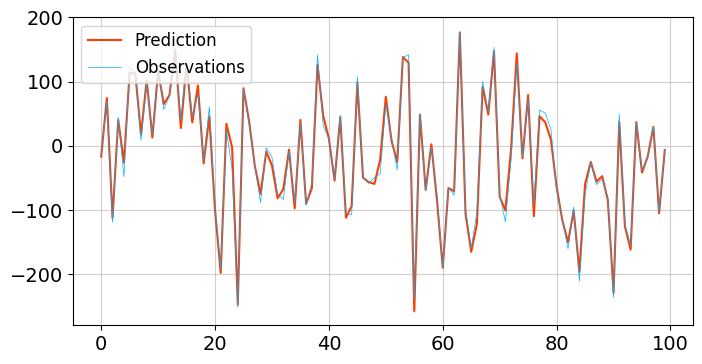

In [46]:
import matplotlib.pyplot as plt
y_pred = model.predict(X)
print(X.shape, y_pred.shape, Y.shape)
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(y_pred,color='#ff3d00',label="Prediction",linewidth=1.5)
ax.plot(Y,color='#00b0ff',label="Observations",linewidth=0.5)

ax.legend(loc="upper left",fontsize=12)
ax.grid(alpha=0.6)
ax.tick_params(labelsize=14)

# 残差分析
## 异方差检验
- 检验多元线性回归方差是否存在异方差
这部分代码进行了白氏异方差检验（White test），用于检查回归模型残差的异方差性，即残差的方差是否随自变量的变化而变化。
使用 spec_white 函数计算测试统计量、p值和自由度。
如果p值较小，表示存在异方差性，这会影响模型估计的效率和假设检验的有效性。

In [43]:
from statsmodels.stats.diagnostic import spec_white

X = feature
X = sm.add_constant(X) # 添加截距项
error = model.resid  #模型的残差(residual)
statistic, p, n = spec_white(error, X)
print("The test statistic: {};\n\
P Value: {};\n\
The degree of Freedom: {};".format(statistic, p, n))

The test statistic: 16.472061706322467;
P Value: 0.6869404563871935;
The degree of Freedom: 20;


p 值较小，0.01860573615713307。具有明显的异方差性，严重影响线性模型性能
p 值较大，0.6869404563871935。无明显的异方差性。

## 自相关性检验
- 这部分代码进行了布鲁施-戈弗雷自相关性检验（Breusch-Godfrey test），用于检查回归模型残差中的自相关性。
- 自相关性指的是残差中一个误差项与其前一个误差项相关联的情况。
- 使用 acorr_breusch_godfrey 函数计算拉格朗日乘数（LM）统计量、LM的p值、F统计量及其p值。
- 显著的LM统计量或F统计量（即低p值）表明残差中存在自相关性，这可能表示模型中遗漏了一些重要的解释变量或者数据中存在时间序列相关性。

In [45]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
lm, p_lm, f, p_f = acorr_breusch_godfrey(model)
print("Lagrange multiplier test statistic: {};\n\
P Value-LM: {};\n\
F Statistic: {};\n\
P Value-F {}: ".format(lm, p_lm, f, p_f))

Lagrange multiplier test statistic: 13.745889769873564;
P Value-LM: 0.18490106398716072;
F Statistic: 1.3386663401764307;
P Value-F 0.22374083469481737: 


- 拉格朗日乘数（Lagrange Multiplier, LM）统计量: 13.7459。这个统计量用于检测残差中的自相关性。数值越大，表示自相关性的可能性越高。
- LM的P值（P Value-LM）: 0.1849。这是LM统计量对应的p值。它表示在零假设（残差中不存在自相关性）为真的条件下，观察到当前或更极端LM统计量的概率。在大多数情况下，如果p值小于0.05，则认为结果在统计上显著，从而拒绝零假设。在这个例子中，p值大于0.05，因此没有足够的证据表明残差中存在自相关性。
- F统计量: 1.3387。这是另一种检测残差中自相关性的方法。
- F统计量的P值（P Value-F）: 0.2237。与LM的p值类似，这是F统计量的p值。它同样高于0.05的常用显著性水平，这意味着我们没有足够的证据拒绝零假设。